In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [2]:
plt.style.use('dark_background') 

def highlight_odd_rows(s):
    '''
    Changes style of a dataframe visualization
    Args:
       s : The row of the dataframe
    Returns:
    '''
    styles = []
    for i in range(len(s)):
        if i % 2 == 1:
            styles.append('background-color: indigo; border: 1px solid white;')
        else:
            styles.append('border: 1px solid white;')
    return styles

In [3]:
df = pd.read_csv("vinsconsultadossec.csv", encoding = 'utf-8')
df = df.fillna('xD');

In [71]:
list(df.columns

Index(['VIN', '_id', 'host', 'ip', 'apiKey', 'userId', 'idReporte',
       'requestParameters', 'requestUrl', 'responseCode', 'responseCodeStatus',
       'requestTime', 'responseTime', 'labels', 'idRespuesta', 'idConsulta',
       'responseBody', 'carfaxUsaData', 'alertas', 'firewallUsa'],
      dtype='object')

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500000 entries, 0 to 1499999
Data columns (total 20 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   VIN                 1500000 non-null  object
 1   _id                 1500000 non-null  object
 2   host                1500000 non-null  object
 3   ip                  1500000 non-null  object
 4   apiKey              1500000 non-null  object
 5   userId              1500000 non-null  object
 6   idReporte           1500000 non-null  object
 7   requestParameters   1500000 non-null  object
 8   requestUrl          1500000 non-null  object
 9   responseCode        1500000 non-null  object
 10  responseCodeStatus  1500000 non-null  object
 11  requestTime         1500000 non-null  object
 12  responseTime        1500000 non-null  object
 13  labels              1500000 non-null  object
 14  idRespuesta         1500000 non-null  object
 15  idConsulta          1500000 non-

In [4]:
df.head().style.apply(highlight_odd_rows)

,VIN,_id,host,ip,apiKey,userId,idReporte,requestParameters,requestUrl,responseCode,responseCodeStatus,requestTime,responseTime,labels,idRespuesta,idConsulta,responseBody,carfaxUsaData,alertas,firewallUsa
0,54DC4W1B4JS801424,67476b71d3f2cffed27c1a20,10.240.2.38:80,"201.116.128.213:23939,10.240.6.41, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,xD,xD,{},/v2/regularizacion/54DC4W1B4JS801424,200.000000,ok,2024-11-27 12:56:49,2024-11-27 12:56:50,xD,67476b72d3f2cffed27c1a21,67476b71d3f2cffed27c1a20,"{""mensajes"":[],""robo"":false,""roboFecha"":null,""marca"":""ISUZU"",""modelo"":""NPR HD"",""anioModelo"":""2018"",""fabricante"":""THE SHYFT GROUP, INC."",""paisOrigen"":""ESTADOS UNIDOS (USA)"",""tiempoConsulta"":""2024-11-27T12:56:49-06:00"",""tiempoRespuesta"":""2024-11-27T12:56:50-06:00""}","{""vin"":""54DC4W1B4JS801424"",""timestamp"":""2024-11-27T12:56:49.000"",""components"":{""potentialFraudFile"":{""year"":2018,""make"":""ISUZU"",""model"":""NPR HD"",""rateEvasionFlags"":[""Non-Personal Ownership Type""],""potentialFraudFlags"":[],""vinCloningFlags"":[]}},""customCalculationOdometer"":""""}",[],0
1,3C4FY58B15T541154,67476b5d67c0ea853a9d92b8,10.240.2.38:80,"201.116.128.213:23938,10.240.0.249, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,xD,xD,{},/v2/regularizacion/3C4FY58B15T541154,200.000000,ok,2024-11-27 12:56:29,2024-11-27 12:56:29,xD,67476b5d67c0ea853a9d92b9,67476b5d67c0ea853a9d92b8,"{""mensajes"":[],""robo"":false,""roboFecha"":null,""marca"":""CHRYSLER"",""modelo"":""PT CRUISER TOURING"",""anioModelo"":""2005"",""fabricante"":""CHRYSLER DE MEXICO TOLUCA"",""paisOrigen"":""MÉXICO"",""tiempoConsulta"":""2024-11-27T12:56:29-06:00"",""tiempoRespuesta"":""2024-11-27T12:56:29-06:00""}","{""vin"":""3C4FY58B15T541154"",""timestamp"":""2024-11-27T12:48:36.000"",""components"":{""potentialFraudFile"":{""year"":2005,""make"":""CHRYSLER"",""model"":""PT CRUISER TOURING"",""rateEvasionFlags"":[],""potentialFraudFlags"":[],""vinCloningFlags"":[]}},""customCalculationOdometer"":""""}",[],1
2,1GKS1CE00ER249129,67476b591159e5a4ec46f6a9,10.240.2.38:80,"201.116.128.213:23938,10.240.0.249, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,xD,xD,{},/v2/regularizacion/1GKS1CE00ER249129,200.000000,ok,2024-11-27 12:56:25,2024-11-27 12:56:26,xD,67476b5a1159e5a4ec46f6aa,67476b591159e5a4ec46f6a9,"{""mensajes"":[],""robo"":false,""roboFecha"":null,""marca"":""GMC"",""modelo"":""YUKON SLT"",""anioModelo"":""2014"",""fabricante"":""GENERAL MOTORS LLC"",""paisOrigen"":""ESTADOS UNIDOS (USA)"",""tiempoConsulta"":""2024-11-27T12:56:25-06:00"",""tiempoRespuesta"":""2024-11-27T12:56:26-06:00""}","{""vin"":""1GKS1CE00ER249129"",""timestamp"":""2024-11-27T12:56:25.000"",""components"":{""potentialFraudFile"":{""year"":2014,""make"":""GMC"",""model"":""YUKON SLT"",""rateEvasionFlags"":[],""potentialFraudFlags"":[""Out Of Operation""],""vinCloningFlags"":[]}},""customCalculationOdometer"":""""}",[],0
3,3C4FY58B15T541154,67476b3f831d3a07f8041407,10.240.2.38:80,"201.116.128.213:23937,10.240.6.41, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,xD,xD,{},/v2/regularizacion/3C4FY58B15T541154,200.000000,ok,2024-11-27 12:55:59,2024-11-27 12:56:00,xD,67476b40831d3a07f8041408,67476b3f831d3a07f8041407,"{""mensajes"":[],""robo"":false,""roboFecha"":null,""marca"":""CHRYSLER"",""modelo"":""PT CRUISER TOURING"",""anioModelo"":""2005"",""fabricante"":""CHRYSLER DE MEXICO TOLUCA"",""paisOrigen"":""MÉXICO"",""tiempoConsulta"":""2024-11-27T12:55:59-06:00"",""tiempoRespuesta"":""2024-11-27T12:56:00-06:00""}","{""vin"":""3C4FY58B15T541154"",""timestamp"":""2024-11-27T12:48:36.000"",""components"":{""potentialFraudFile"":{""year"":2005,""make"":""CHRYSLER"",""model"":""PT CRUISER TOURING"",""rateEvasionFlags"":[],""potentialFraudFlags"":[],""vinCloningFlags"":[]}},""customCalculationOdometer"":""""}",[],1
4,WBAGC4314MDC27563,67476b33876812cd76cf5350,10.240.2.38:80,"201.116.128.213:23936,10.240.5.208, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,xD,xD,{},/v2/regularizacion/WBAGC4314MDC27563,200.000000,ok,2024-11-27 12:55:47,2024-11-27 12:55:53,xD,6747

In [5]:
def getDfSize(df):
    rows = len(df.axes[0])
    columns = len(df.axes[1])

    return {'rows': rows, 'columns': columns}

In [6]:
getDfSize(df)

{'rows': 1500000, 'columns': 20}

<h3>La siguiente función extrae las distintas llaves de cada diccionario que contenga una columna como valor en el dataframe</h3>

In [7]:
def determineDistinctKeys(columnToList): #Recibe una lista, no una dataframe column
    '''
    Extracts the keys of a dictionary list and saves it in a dictionary with its count of appearences in the list
    Args:
       columnList (list) : List of dictionary to extract the keys
    Returns:
       distinctKeys (dictionary): A dictionary with the keys as a string and its appearences count in the list
    '''
    distinctKeysDict = {}
    distinctKeysList = []
    for dictionary in columnToList:
        if str(dictionary)[0] == "{" :
            dictionary = json.loads(dictionary)
            orderedKeys = sorted(list(dictionary.keys()))
            if orderedKeys in distinctKeysList:
                distinctKeysDict['/'.join(orderedKeys)] += 1
            else:
                distinctKeysList.append(orderedKeys)
                distinctKeysDict['/'.join(orderedKeys)] = 1
        else:
            if ''.join(['notKey:',dictionary]) in distinctKeysList:
                distinctKeysDict[''.join(['notKey:',dictionary])] += 1
            else:
                distinctKeysList.append(''.join(['notKey:',dictionary]))
                distinctKeysDict[''.join(['notKey:',dictionary])] = 1
    return distinctKeysDict

<h3>La siguiente función extrae los distintos valores de una columna en el dataframe</h3>

In [8]:
def determineDistinctValues(df, col):
    '''
    Determines the unrepeated values in a columns
    Args:
       df (DataFrame) : Dataframe which contains the column to search
       col (string) : Column's name to search
    Returns:
       df[col].unique() (array): An array (iterable object) with the unrepeated values of the column
    '''
    return df[col].unique()

<h3>Con esto sabemos que la columna "Response Body" tiene un cuerpo idéntico para todos los casos</h3>

In [9]:
responseBody = df['responseBody'].values.tolist()

In [10]:
df[df['responseBody']=='Error: getaddrinfo EAI_AGAIN complementos.mysql.database.azure.com']

,VIN,_id,host,ip,apiKey,userId,idReporte,requestParameters,requestUrl,responseCode,responseCodeStatus,requestTime,responseTime,labels,idRespuesta,idConsulta,responseBody,carfaxUsaData,alertas,firewallUsa
1143898,3N1BC1CP7AL455563,66822fd740f55bdc83ea0cd6,10.240.2.38:80,"201.116.128.213:55260,10.240.1.169, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,xD,xD,{},/v2/regularizacion/3N1BC1CP7AL455563,500.0,error,2024-6-30 23:25:59,2024-6-30 23:26:05,xD,66822fdd40f55bdc83ea0cd9,66822fd740f55bdc83ea0cd6,Error: getaddrinfo EAI_AGAIN complementos.mysq...,xD,xD,0
1153544,1G6DE5E57C0148822,667f090a965b5823274fe85d,10.240.2.38:80,"201.116.128.213:49450,10.240.1.225, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,xD,xD,{},/v2/regularizacion/1G6DE5E57C0148822,500.0,error,2024-6-28 14:03:38,2024-6-28 14:03:46,xD,667f0912965b5823274fe861,667f090a965b5823274fe85d,Error: getaddrinfo EAI_AGAIN complementos.mysq...,xD,xD,0


In [11]:
determineDistinctKeys(responseBody)

{'anioModelo/fabricante/marca/mensajes/modelo/paisOrigen/robo/roboFecha/tiempoConsulta/tiempoRespuesta': 1482036,
 '_id/error/message/statusCode': 1765,
 '_id/anioModelo/fabricante/historialUSA_CAN/marca/mensajes/modelo/paisOrigen/robo/roboFecha/tiempoConsulta/tiempoRespuesta': 2,
 'message/name/options/response/status': 28,
 'anioModelo/marca/mensajes/modelo/robo/roboFecha/tiempoConsulta/tiempoRespuesta': 9716,
 'fabricante/mensajes/paisOrigen/tiempoConsulta/tiempoRespuesta': 6429,
 'mensajes/tiempoConsulta/tiempoRespuesta': 22,
 'notKey:Error: getaddrinfo EAI_AGAIN complementos.mysql.database.azure.com': 2}

<h3>Con esto sabemos la proporción entre consultas con algún tipo de error, o consultas normales en Carfax  USA</h3>

In [12]:
carfaxUsaData = df['carfaxUsaData'].values.tolist()

In [13]:
determineDistinctKeys(carfaxUsaData)

{'components/customCalculationOdometer/timestamp/vin': 1302676,
 'error/respuestaCompleta': 175332,
 'notKey:xD': 8246,
 'error/timestamp/vin/vinSuggestions': 1466,
 'VHR/components/customCalculationOdometer/timestamp/vin': 12280}

In [14]:
df[df['carfaxUsaData']=='xD'].shape

(8246, 20)

<h3>Finalmente sabemos qué se pide en los "Request Parameters"</h3>

In [15]:
requestParameters = df['requestParameters'].values.tolist()

In [16]:
determineDistinctKeys(requestParameters)

{'': 1500000}

<h3>Ahora nos aseguramos de todos los valores distintos que haya en las columnas</h3>

In [17]:
determineDistinctValues(df, 'apiKey') #Solo existe un valor posible para este campo

array(['6cNqbbTqBnZEchPZ2YYn', '0fuPXLN8ZtW4nTSOosDL'], dtype=object)

In [18]:
len(list(determineDistinctValues(df, 'ip')))

783548

In [19]:
#vinsByIp = list(df.groupby('ip')['VIN'].apply(list))
#ips = list(set(df['ip']))
#if len(ips) == len(vinsByIp):
 #   ipsVinsFrame = []
 #   for ipsIndex in range(len(ips)):
  #      ipsVinsFrame.append([ips[ipsIndex], len(set(vinsByIp[ipsIndex]))])
   # ipsVinsFrame = pd.DataFrame(ipsVinsFrame,columns = ['ip', 'count'])
ips_vins_frame = (
    df.groupby('ip')['VIN']
    .nunique()  # Count unique 'VIN's in each group
    .reset_index()  # Convert the series back to a DataFrame
    .rename(columns={'VIN': 'count'})  # Rename the column for clarity
)

In [20]:
ips_vins_frame[ips_vins_frame['count']>3].describe()

,count
count,47174.000000
mean,4.860601
std,1.403752
min,4.000000
25%,4.000000
50%,4.000000
75%,5.000000
max,26.000000


In [21]:
determineDistinctValues(df, 'userId') #Solo existe un valor posible para este campo

array(['xD'], dtype=object)

In [22]:
list(determineDistinctValues(df, 'idReporte')); #Existen varios valores (¿de qué depende esta diferencia?)

In [23]:
determineDistinctValues(df, 'responseCode') #Solo existe un valor posible para este campo

array([200.0, 401.0, 'xD', 500.0], dtype=object)

In [24]:
df[df['responseCode']=='xD']

,VIN,_id,host,ip,apiKey,userId,idReporte,requestParameters,requestUrl,responseCode,responseCodeStatus,requestTime,responseTime,labels,idRespuesta,idConsulta,responseBody,carfaxUsaData,alertas,firewallUsa
24265,%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%...,6740afc574141818244e5d15,10.240.2.38:80,"201.116.128.213:11168,10.240.5.233, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,xD,xD,{},/v2/regularizacion/%20%20%20%20%20%20%20%20%20...,xD,xD,2024-11-22 10:22:29,xD,xD,6740afc574141818244e5d16,6740afc574141818244e5d15,"{""response"":{""statusCode"":400,""message"":""Para ...",xD,[],0
24266,%20%20,6740afc35fdba73a823e4571,10.240.2.38:80,"201.116.128.213:11168,10.240.10.0, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,xD,xD,{},/v2/regularizacion/%20%20,xD,xD,2024-11-22 10:22:27,xD,xD,6740afc35fdba73a823e4572,6740afc35fdba73a823e4571,"{""response"":{""statusCode"":400,""message"":""Para ...",xD,[],0
24267,%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20,6740afc374141818244e5d13,10.240.2.38:80,"201.116.128.213:11168,10.240.8.27, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,xD,xD,{},/v2/regularizacion/%20%20%20%20%20%20%20%20%20...,xD,xD,2024-11-22 10:22:27,xD,xD,6740afc374141818244e5d14,6740afc374141818244e5d13,"{""response"":{""statusCode"":400,""message"":""Para ...",xD,[],0
24268,%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20,6740afbc74141818244e5d11,10.240.2.38:80,"201.116.128.213:11166,10.240.0.10, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,xD,xD,{},/v2/regularizacion/%20%20%20%20%20%20%20%20%20...,xD,xD,2024-11-22 10:22:20,xD,xD,6740afbc74141818244e5d12,6740afbc74141818244e5d11,"{""response"":{""statusCode"":400,""message"":""Para ...",xD,[],0
24269,%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20,6740afbb5fdba73a823e456f,10.240.2.38:80,"201.116.128.213:11166,10.240.8.27, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,xD,xD,{},/v2/regularizacion/%20%20%20%20%20%20%20%20%20...,xD,xD,2024-11-22 10:22:19,xD,xD,6740afbb5fdba73a823e4570,6740afbb5fdba73a823e456f,"{""response"":{""statusCode"":400,""message"":""Para ...",xD,[],0
24270,%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20,6740afba12327586f2ae800c,10.240.2.38:80,"201.116.128.213:11166,10.240.10.0, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,xD,xD,{},/v2/regularizacion/%20%20%20%20%20%20%20%20%20...,xD,xD,2024-11-22 10:22:18,xD,xD,6740afba12327586f2ae800d,6740afba12327586f2ae800c,"{""response"":{""statusCode"":400,""message"":""Para ...",xD,[],0
24271,%20%20%20%20%20%20%20%20%20%20%20%20%20%20,6740afb974141818244e5d0f,10.240.2.38:80,"201.116.128.213:11166,10.240.10.0, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,xD,xD,{},/v2/regularizacion/%20%20%20%20%20%20%20%20%20...,xD,xD,2024-11-22 10:22:17,xD,xD,6740afb974141818244e5d10,6740afb974141818244e5d0f,"{""response"":{""statusCode"":400,""message"":""Para ...",xD,[],0
24272,%20%20%20%20%20%20%20%20%20%20%20%20%20%20,6740afb65fdba73a823e456d,10.240.2.38:80,"201.116.128.213:11166,10.240.0.10, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,xD,xD,{},/v2/regularizacion/%20%20%20%20%20%20%20%20%20...,xD,xD,2024-11-22 10:22:14,xD,xD,6740afb65fdba73a823e456e,6740afb65fdba73a823e456d,"{""response"":{""statusCode"":400,""message"":""Para ...",xD,[],0
24273,%20%20%20%20%20%20%20%20%20%20%20%20%20%20,6740afb512327586f2ae800a,10.240.2.38:80,"201.116.128.213:11166,10.240.0.10, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,xD,xD,{},/v2/regularizacion/%20%20%20%20%20%20%20%20%20...,xD,xD,2024-11-22 10:22:13,xD,xD,6740afb512327586f2ae800b,6740afb512327586f2ae800a,"{""response"":{""statusCode"":400,""message"":""Para ...",xD,[],0
24274,%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%...,6740afb35fdba73a823e456b,10.240.2.38:80,"201.116.128.213:11166,10.240.10.0, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,xD,xD,{},/v2/regularizacion/%20%20%20%20%20%20%20%20%20...,xD,xD,2024-11-22 10:22:11,xD,xD,6740afb35fdba73a823e456c,6740afb35fdba73a823e456b,"{""response"":{""statusCode"":400,""message"":""Para ...",xD,[],0


In [25]:
determineDistinctValues(df, 'responseCodeStatus') #Solo existe un valor posible para este campo

array(['ok', 'error', 'xD'], dtype=object)

In [26]:
determineDistinctValues(df, 'labels') #Solo existe un valor posible para este campo

array(['xD'], dtype=object)

In [27]:
determineDistinctValues(df, 'firewallUsa') #Solo existe un valor posible para este campo

array([0, 1])

<h3>A continuación busco los distintos tipos de código de alerta que se encuentran en el dataframe creando una función especial para ello </h3>

In [28]:
def countAlertCodes(df, alertsColumn: str):
    '''
    Counts the alert codes in a column of a dataframe
    Args:
       df (DataFrame) : Dataframe which contains the column to search
       alertsColumn (string) : Column's name to search
    Returns:
       codeCount (dictionary): A dictionary with the distinct alert codes as keys and the appearence count in the column
    '''
    alertsWithCode = filter(lambda x: x != [],df['alertas'].values.tolist())
    codeCount = {'Code 1': 0 , 'Code 2': 0, 'Code 3': 0, 'Code 4': 0, 'Code 5': 0, 'Code 6': 0, 'Code 7': 0, 'invalid': 0}

    for alert in alertsWithCode:
        if str(alert)[0] =='[':
            alertList = json.loads(alert)
            if alertList != []:
                for subalert in alertList:
                    n = subalert['codigo']
                    codeCount[''.join(['Code ', str(n)])] += 1
        else:
           codeCount['invalid']+=1

    return codeCount 


In [29]:
countAlertCodes(df, 'alertas')

{'Code 1': 12654,
 'Code 2': 4923,
 'Code 3': 9143,
 'Code 4': 128321,
 'Code 5': 7557,
 'Code 6': 12761,
 'Code 7': 36994,
 'invalid': 1767}

<h3>Ahora calculo el tiempo en que se tarda cada petición en generar una respuesta</h3>

In [30]:
def calculateDeltaTime(df, columnA, columnB):
    '''
    Converts columnA and columnB in datetime type and makes the difference between both columns
    Args:
       df (DataFrame) : Dataframe which contains the columns to substraction
       columnA (string) : Minuend column
       columnB (string): Substrahend column
    Returns:
       responsePeriod (DataFrame): Returns a column of the seconds difference as a dataframe
    '''
    responseTimeType = pd.to_datetime(df[columnA])
    requestTimeType = pd.to_datetime(df[columnB])
    responsePeriod = (responseTimeType - requestTimeType).to_frame()
    responsePeriod['secondsDifference'] = pd.to_timedelta(responsePeriod[0]).dt.total_seconds()
    responsePeriod.drop([0], axis='columns', inplace=True)

    return responsePeriod

<h4>Con mayor frecuencia parece tardarse un segundo la respuesta. La gráfica parece ajustarse a una distribución de Poisson o a una distribución normal. Checar cuál es la más conveniente para calcular probabilidades</h4>

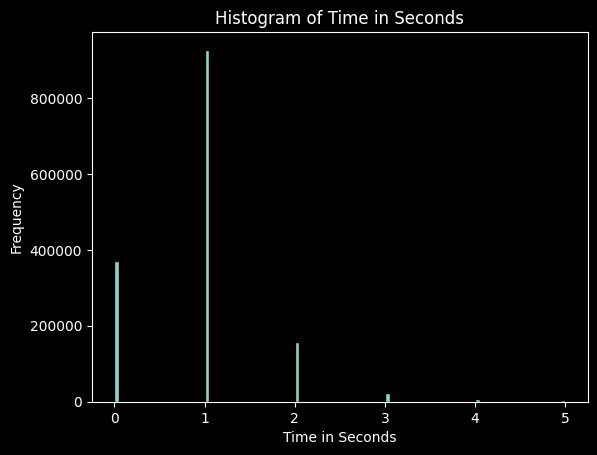

In [31]:
timeFrame = calculateDeltaTime(df[(df['responseTime']!='xD')&(df['requestTime']!='xD')], 'responseTime', 'requestTime')
plt.hist(timeFrame[timeFrame['secondsDifference']<6]['secondsDifference'], bins = 100, edgecolor = 'black')
plt.xlabel('Time in Seconds')
plt.ylabel('Frequency')
plt.title('Histogram of Time in Seconds')
plt.show()

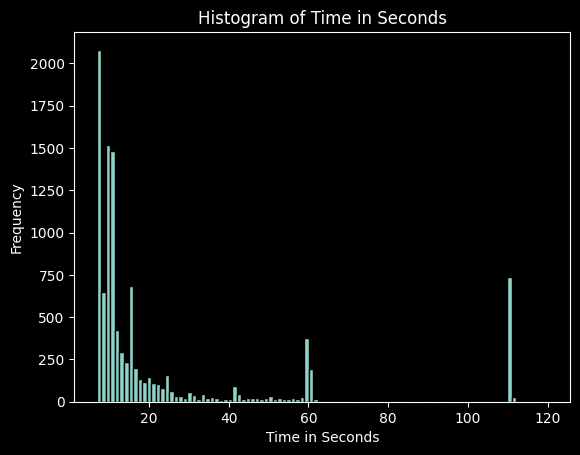

In [32]:
plt.hist(timeFrame[timeFrame['secondsDifference']>6]['secondsDifference'], bins = 100, edgecolor = 'black')
plt.xlabel('Time in Seconds')
plt.ylabel('Frequency')
plt.title('Histogram of Time in Seconds')
plt.show()

In [33]:
timeFrame.describe().style.apply(highlight_odd_rows)

,secondsDifference
count,1499972.000000
mean,1.086068
std,3.170337
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,120.000000


In [34]:
timeFrame[timeFrame['secondsDifference'] <= 6].describe().style.apply(highlight_odd_rows)

,secondsDifference
count,1489261.000000
mean,0.920419
std,0.726302
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,6.000000


In [35]:
timeFrame[timeFrame['secondsDifference'] > 6].describe().style.apply(highlight_odd_rows)

,secondsDifference
count,10711.000000
mean,24.117916
std,28.284225
min,7.000000
25%,9.000000
50%,11.000000
75%,21.000000
max,120.000000


In [36]:
timeFrame.max().values.tolist()

[120.0]

<h3>A continuación se comprueba que cada diccionario del valor de la columna 'carfaxUsaData' con una llave "error" le corresponda un valor distinto a lista vacía en la columna 'alertas'</h3>

In [37]:
def proveErrorAlert(df):
    '''
    Assures every error in CarfaxUsaData is associated with an alert
    Args:
       df (DataFrame) : Dataframe which contains the columns to substraction
    Returns:
       ... (string): Returns a status message
    '''
    carfaxUsaData = df['carfaxUsaData'].values.tolist()
    conError = 0
    for index1 in range(len(carfaxUsaData)):
        carfaxDict = json.loads(carfaxUsaData[index1])
        if 'error' in list(carfaxDict.keys()):
            conError += 1
            if df.iloc[index1]['alertas'] == []:
                return 'Existe un valor con error y sin alerta'
    return 'Funciona correctamente'

In [38]:
proveErrorAlert(df[df['carfaxUsaData']!='xD'])

'Funciona correctamente'

<h3>Ahora se estudiará la relación con los Vin's repetidos y las alertas</h3>

In [39]:
def getRepeatedValuesInAColumn(df, columnName):
    '''
    Identifies the repeated values of a column in a dataframe
    Args:
       df (DataFrame) : Dataframe which contains the columns to search
       columnName (string) : Column's name to search
    Returns:
       duplicates['VIN'] (pandas Series): Returns a column as a pandas series of the duplicated values of the columnName
    '''
    duplicates = df[df.duplicated(subset=[columnName], keep=False)]
    return duplicates['VIN']

In [40]:
def searchValuesInADataframe(df, values:list, columnA: str, columnB: str)-> dict:
    '''
    Optimized version to search values in a dataframe columnA and retrieve the corresponding values of columnB.
    Args:
       values (list): The list of values to be searched.
       columnA (str): The name of the column to search.
       columnB (str): The name of the column to retrieve values from.
       df (DataFrame): The dataframe to search in.
    Returns:
      grouped: A dictionary with keys as the values from columnA and values as the list of corresponding entries from columnB.
    '''

    filtered_df = df[df[columnA].isin(values)]
    
    grouped = filtered_df.groupby(columnA)[columnB].apply(list).to_dict()
    
    return grouped

In [41]:
proofRepeated = getRepeatedValuesInAColumn(df, 'VIN').unique().tolist()

In [42]:
repeatedValues = searchValuesInADataframe(df, proofRepeated, 'VIN', 'alertas')

<h4>Identificamos si existe algún VIN repetido que contenga y a la vez no, mensajes de alerta. Además se identifica la cantidad de veces que se repiten los VIN's que lanzan alerta contra los que no lanzan ninguna alerta</h4>

In [43]:
def getIncorrectRepeatedVinInformation(df)->dict:
    '''
    Searches the values of a list in a dataframe columnA and retrieves the information of columnB
    Args:
       df (DataFrame): The dataframe where where will be searched
    Returns:
      ... (dict): A dictionary which contains a status message, a list of good and bad VINs withits appeareance count, and the total count of good and bad VINS
    '''
    vinValues = getRepeatedValuesInAColumn(df, 'VIN').unique().tolist()
    repeatedValues = searchValuesInADataframe(df, vinValues, 'VIN', 'alertas')
    goodVins = 0
    badVins = 0
    goodVinsList = []
    badVinsList = []
    messages = []
    for repeatedVin in list(repeatedValues.keys()):
        differentValuesByVin = list(set(repeatedValues[repeatedVin]))
        for differentValue in differentValuesByVin:
            if differentValue == '[]':
                goodVins += 1
                if len(differentValuesByVin)>1:
                    messages.append(''.join(['Alerta con vin: ',repeatedVin, ' , tiene y no tiene alertas.']))
                else:
                    goodVinsList.append([repeatedVin, len(repeatedValues[repeatedVin])])
            else:
                badVins += 1
                badVinsList.append([repeatedVin, len(repeatedValues[repeatedVin])])
            
    messages.append(''.join(['VINs repetidos que no lanzan alerta: ', str(goodVins), '\nVINs repetidos que sí lanzan alerta: ', str(badVins)]))
    return {'message': messages,
           'goodVinsList': goodVinsList,
           'badVinsList': badVinsList,
           'goodVins':goodVins,
           'badVins': badVins}

In [44]:
incorrectInformation = getIncorrectRepeatedVinInformation(df)

In [45]:
incorrectInformation['message']

['Alerta con vin: 10A2C43DA47314F42 , tiene y no tiene alertas.',
 'Alerta con vin: 11111111111111111 , tiene y no tiene alertas.',
 'Alerta con vin: 11516161665626526 , tiene y no tiene alertas.',
 'Alerta con vin: 12356KPMM23332563 , tiene y no tiene alertas.',
 'Alerta con vin: 19UUB2FY2FA005748 , tiene y no tiene alertas.',
 'Alerta con vin: 19XFB2F59CE038759 , tiene y no tiene alertas.',
 'Alerta con vin: 19XFC1F38GE205740 , tiene y no tiene alertas.',
 'Alerta con vin: 1B3BD1FB0BN531766 , tiene y no tiene alertas.',
 'Alerta con vin: 1B3CB3HA7BD116474 , tiene y no tiene alertas.',
 'Alerta con vin: 1B3CB4HA8AD607304 , tiene y no tiene alertas.',
 'Alerta con vin: 1B7GG22Y8XS218629 , tiene y no tiene alertas.',
 'Alerta con vin: 1B7HC16Y01S157515 , tiene y no tiene alertas.',
 'Alerta con vin: 1B7HC16Y7TJ202443 , tiene y no tiene alertas.',
 'Alerta con vin: 1B7MF33D2WJ150064 , tiene y no tiene alertas.',
 'Alerta con vin: 1C3CCCAB1GN119361 , tiene y no tiene alertas.',
 'Alerta c

In [46]:
def diagnoseVins(df, incorrectInformation):
    '''
    Converts the lists of  getIncorrectRepeatedVinInformation() function in dataframes
    Args:
       df (DataFrame): The dataframe where where will be searched
    Returns:
      ... (dict): A dictionary which contains the good and bad VINs dataframes and the good and bad repeated Records of the VINs
    '''
    goodVinsFrame = pd.DataFrame(incorrectInformation['goodVinsList'], columns = ['VIN', 'repeatedTimes'])
    goodRepeatedRecords = goodVinsFrame.sum()['repeatedTimes']
    badVinsFrame = pd.DataFrame(incorrectInformation['badVinsList'], columns = ['VIN', 'repeatedTimes'])
    badRepeatedRecords = badVinsFrame.sum()['repeatedTimes']

    return {'goodVinsFrame': goodVinsFrame, 'badVinsFrame': badVinsFrame, 'goodRepeatedRecords': goodRepeatedRecords, 'badRepeatedRecords': badRepeatedRecords}

In [47]:
diagnosedVins = diagnoseVins(df, incorrectInformation)

In [48]:
diagnosedVins['goodVinsFrame'].describe().style.apply(highlight_odd_rows)

,repeatedTimes
count,186124.000000
mean,5.243762
std,8.364984
min,2.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,626.000000


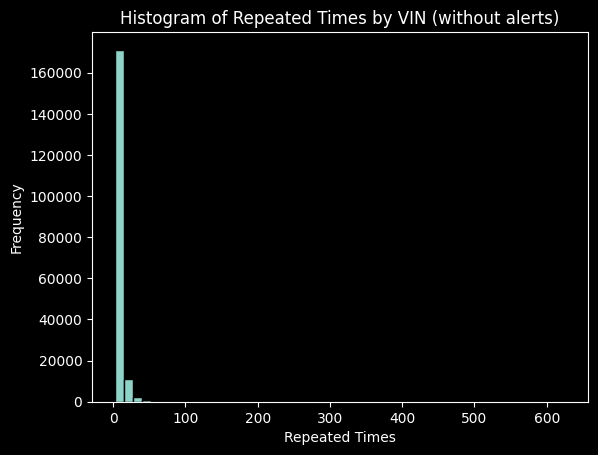

In [49]:
plt.hist(diagnosedVins['goodVinsFrame']['repeatedTimes'], bins = 50, edgecolor = 'black')
plt.xlabel('Repeated Times')
plt.ylabel('Frequency')
plt.title('Histogram of Repeated Times by VIN (without alerts)')
plt.show()

In [50]:
diagnosedVins['badVinsFrame'].describe().style.apply(highlight_odd_rows)

,repeatedTimes
count,31183.000000
mean,4.639740
std,6.623188
min,2.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,252.000000


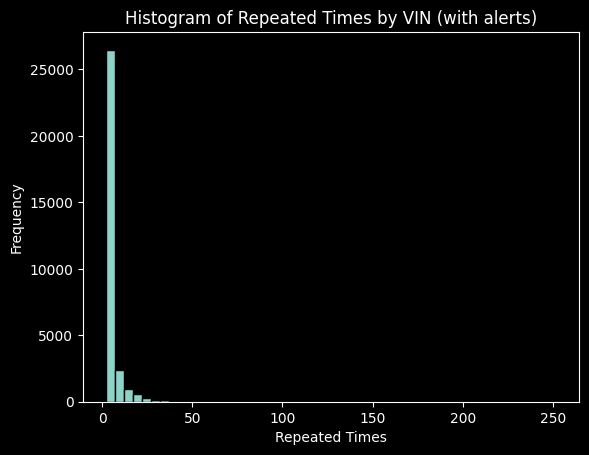

In [51]:
plt.hist(diagnosedVins['badVinsFrame']['repeatedTimes'], bins = 50, edgecolor = 'black')
plt.xlabel('Repeated Times')
plt.ylabel('Frequency')
plt.title('Histogram of Repeated Times by VIN (with alerts)')
plt.show()

<h4>Finalmente tenemos los VINs revisados en todos los registros. La proporción entre VINs repetidos con alerta, VINs repetidos sin alerta. Máximos y mínimos repeticiones</h4>

Cantidad de registros repetidos:  1120671
Cantidad de registros repetidos con VINs sin alerta:  975990
Cantidad de registros repetidos con VINs con alerta:  144681
Cantidad de VINs revisados en esos registros repetidos:  217307


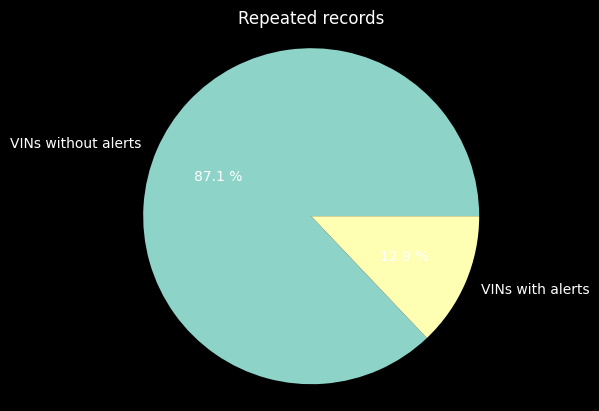

In [52]:
print('Cantidad de registros repetidos: ', diagnosedVins['goodRepeatedRecords'] + diagnosedVins['badRepeatedRecords'])
print('Cantidad de registros repetidos con VINs sin alerta: ', diagnosedVins['goodRepeatedRecords'])
print('Cantidad de registros repetidos con VINs con alerta: ', diagnosedVins['badRepeatedRecords'])
print('Cantidad de VINs revisados en esos registros repetidos: ', list(diagnosedVins['badVinsFrame'].count() + diagnosedVins['goodVinsFrame'].count())[1])
repetitionProportion = [diagnosedVins['goodRepeatedRecords'], diagnosedVins['badRepeatedRecords']]
labelsRepetition = ['VINs without alerts', 'VINs with alerts']
plt.pie(repetitionProportion, labels=labelsRepetition, autopct="%0.1f %%")
plt.axis("equal")
plt.title('Repeated records')
plt.show()

<h3>Ahora se comprueba que para cada VIN repetido se dió exactamente la misma información, y en caso de tener alerta, también se dieron las mismas alertas</h3>

In [53]:
def verifyInfoRepeatedVins(df):
    '''
    Verifies every repeated VIN has the same information in every record (due to the short period time reviewed)
    Args:
       df (DataFrame): The dataframe where where will be searched
    Returns:
      ... (dict): A dictionary which contains the different responses as a dict for every repeated VIN in uniqueResponses and VINs with more than one response in differentResponse key
    '''
    uniqueResponses = {}
    differentResponses = {}
    vinValues = getRepeatedValuesInAColumn(df, 'VIN').unique().tolist()
    repeatedValues = searchValuesInADataframe(df, vinValues, 'VIN', 'responseBody')
    repeatedVins = repeatedValues.keys()
    for vin in repeatedVins:
        uniqueResponses[vin] = []
        listJson = []
        for responseString in repeatedValues[vin]:
            responseJson = json.loads(responseString)
            listJson.append(responseJson)
        repeatedValues[vin] = listJson
    for vin in repeatedVins:
        for responseJson in repeatedValues[vin]:
            keys = list(responseJson.keys())
            info = {}
            if 'anioModelo' in keys:
                if 'fabricante' in keys and 'paisOrigen' in keys:
                    info = {'anioModelo': responseJson['anioModelo'], 'fabricante': responseJson['fabricante'], 'marca': responseJson['marca'], 'modelo': responseJson['modelo'], 'paisOrigen': responseJson['paisOrigen'], 'robo': responseJson['robo'], 'roboFecha': responseJson['roboFecha'], 'codes': []}
                else:
                     info = {'anioModelo': responseJson['anioModelo'], 'marca': responseJson['marca'], 'modelo': responseJson['modelo'], 'robo': responseJson['robo'], 'roboFecha': responseJson['roboFecha'], 'codes': []}
            if 'mensajes' in keys and type(responseJson['mensajes'])== 'list' and responseJson['mensajes'] != []:
                    for message in responseJson['mensajes']:
                        if 'codes' in list(message.keys()):
                            info['codes'].append(message['codigo'])
                            info['codes'] = list(set(info['codes']))
                    if info.get('codes')!= None and len(info['codes'])>1:
                        info['codes'] = info['codes'].sort()
            if uniqueResponses[vin] == []:
                 uniqueResponses[vin].append(info)
            else:
                if info not in uniqueResponses[vin]:
                    uniqueResponses[vin].append(info)
                    differentResponses[vin] = info
    return {'uniqueResponses': uniqueResponses, 'differentResponses': differentResponses}

In [54]:
verifyResponses = verifyInfoRepeatedVins(df[df['responseBody']!= 'Error: getaddrinfo EAI_AGAIN complementos.mysql.database.azure.com'])
if verifyResponses['differentResponses'] != {}:
    print('Existen respuestas distintas para un mismo VIN')

Existen respuestas distintas para un mismo VIN


In [55]:
differentResponseVins = list(verifyResponses['differentResponses'].keys())

In [56]:
print(differentResponseVins)

['10A2C43DA47314F42', '11111111111111111', '11516161665626526', '12356KPMM23332563', '19UDE2F42JA004721', '19UUA5662YA024007', '19UUA65595A041932', '19UUA8F56CA020138', '19UUA8F58BA009477', '19UUB2F5XFA001431', '19UUB2F72FA005748', '19UUB2FY2FA005748', '19VDE2E5XEE000761', '19XFA16529E034400', '19XFA1F39BE007408', '19XFA1F52AE080698', '19XFB2F50CE310745', '19XFB2F59CE038759', '19XFB2F59EE007059', '19XFB2F5XFE234973', '19XFB2F82FE269081', '19XFB2F85CE047775', '19XFB2F88FE223366', '19XFC1F34GE007804', '19XFC1F38GE205740', '19XFC1F78GE214148', '19XFC2F73JE000939', '19XFC2F73JE006997', '19XFC2F75GE062576', '19XFC2F75JE043291', '19XFC2F7XHE027677', '1A8HX58N47F537630', '1B3BD1FB0BN531766', '1B3BD4FB8BN617053', '1B3CB1HA4BD209104', '1B3CB3HA3BD268771', '1B3CB3HA7BD116474', '1B3CB3HA7BD116475', '1B3CB4HA1AD602459', '1B3CB4HA2AD613504', '1B3CB4HA8AD607304', '1B3CB4HA9AD600880', '1B3EL36J14N361861', '1B3EL46X46N147847', '1B3ES46C0YD832243', '1B3ES56C55D159869', '1B3HB28B38D645603', '1B3HB48BX8D

In [57]:
for response in differentResponseVins:
    print('VIN', response)
    for information in verifyResponses['uniqueResponses'][response]:
        print(information)
    print('------------')

VIN 10A2C43DA47314F42
{'anioModelo': None, 'fabricante': None, 'marca': None, 'modelo': None, 'paisOrigen': 'Estados Unidos (USA)', 'robo': False, 'roboFecha': None, 'codes': []}
{'anioModelo': None, 'marca': None, 'modelo': None, 'robo': False, 'roboFecha': None, 'codes': []}
------------
VIN 11111111111111111
{'anioModelo': None, 'fabricante': None, 'marca': None, 'modelo': None, 'paisOrigen': 'Estados Unidos (USA)', 'robo': False, 'roboFecha': None, 'codes': []}
{'anioModelo': None, 'marca': None, 'modelo': None, 'robo': False, 'roboFecha': None, 'codes': []}
------------
VIN 11516161665626526
{'anioModelo': None, 'fabricante': None, 'marca': None, 'modelo': None, 'paisOrigen': 'Estados Unidos (USA)', 'robo': False, 'roboFecha': None, 'codes': []}
{'anioModelo': None, 'marca': None, 'modelo': None, 'robo': False, 'roboFecha': None, 'codes': []}
------------
VIN 12356KPMM23332563
{'anioModelo': None, 'marca': None, 'modelo': None, 'robo': False, 'roboFecha': None, 'codes': []}
{'anio

In [58]:
# Cálculo de la probabilidad usando la fórmula previamente descrita
prob_menor_o_igual_a_6 =1-(10711/getDfSize(df)['rows'])
#prob_menor_o_igual_a_6 = 0.99725
print(prob_menor_o_igual_a_6)
prob_ninguno_mayor_a_6 = prob_menor_o_igual_a_6 ** 100
prob_al_menos_uno_mayor_a_6 = 1 - prob_ninguno_mayor_a_6

print(prob_al_menos_uno_mayor_a_6)

0.9928593333333333
0.5116038035749595


In [59]:
print(prob_al_menos_uno_mayor_a_6**2)

0.2617384518323657


In [64]:
#cutoff_date = pd.Timestamp('2024-11-18')
df2 = df[(df['responseTime']!='xD')&(df['requestTime']!='xD')].reset_index()
df2
#df = df[df['responseTime']< cutoff_date]

,index,VIN,_id,host,ip,apiKey,userId,idReporte,requestParameters,requestUrl,...,responseCodeStatus,requestTime,responseTime,labels,idRespuesta,idConsulta,responseBody,carfaxUsaData,alertas,firewallUsa
0,0,54DC4W1B4JS801424,67476b71d3f2cffed27c1a20,10.240.2.38:80,"201.116.128.213:23939,10.240.6.41, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,xD,xD,{},/v2/regularizacion/54DC4W1B4JS801424,...,ok,2024-11-27 12:56:49,2024-11-27 12:56:50,xD,67476b72d3f2cffed27c1a21,67476b71d3f2cffed27c1a20,"{""mensajes"":[],""robo"":false,""roboFecha"":null,""...","{""vin"":""54DC4W1B4JS801424"",""timestamp"":""2024-1...",[],0
1,1,3C4FY58B15T541154,67476b5d67c0ea853a9d92b8,10.240.2.38:80,"201.116.128.213:23938,10.240.0.249, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,xD,xD,{},/v2/regularizacion/3C4FY58B15T541154,...,ok,2024-11-27 12:56:29,2024-11-27 12:56:29,xD,67476b5d67c0ea853a9d92b9,67476b5d67c0ea853a9d92b8,"{""mensajes"":[],""robo"":false,""roboFecha"":null,""...","{""vin"":""3C4FY58B15T541154"",""timestamp"":""2024-1...",[],1
2,2,1GKS1CE00ER249129,67476b591159e5a4ec46f6a9,10.240.2.38:80,"201.116.128.213:23938,10.240.0.249, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,xD,xD,{},/v2/regularizacion/1GKS1CE00ER249129,...,ok,2024-11-27 12:56:25,2024-11-27 12:56:26,xD,67476b5a1159e5a4ec46f6aa,67476b591159e5a4ec46f6a9,"{""mensajes"":[],""robo"":false,""roboFecha"":null,""...","{""vin"":""1GKS1CE00ER249129"",""timestamp"":""2024-1...",[],0
3,3,3C4FY58B15T541154,67476b3f831d3a07f8041407,10.240.2.38:80,"201.116.128.213:23937,10.240.6.41, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,xD,xD,{},/v2/regularizacion/3C4FY58B15T541154,...,ok,2024-11-27 12:55:59,2024-11-27 12:56:00,xD,67476b40831d3a07f8041408,67476b3f831d3a07f8041407,"{""mensajes"":[],""robo"":false,""roboFecha"":null,""...","{""vin"":""3C4FY58B15T541154"",""timestamp"":""2024-1...",[],1
4,4,WBAGC4314MDC27563,67476b33876812cd76cf5350,10.240.2.38:80,"201.116.128.213:23936,10.240.5.208, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,xD,xD,{},/v2/regularizacion/WBAGC4314MDC27563,...,ok,2024-11-27 12:55:47,2024-11-27 12:55:53,xD,67476b39876812cd76cf5351,67476b33876812cd76cf5350,"{""mensajes"":[],""robo"":false,""roboFecha"":null,""...","{""vin"":""WBAGC4314MDC27563"",""timestamp"":""2024-1...",[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1499967,1499995,1C4RJFCT8DC582334,663a6fe043730a5538d30747,10.240.2.38:80,"201.116.128.213:63001,10.240.2.223, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,xD,xD,{},/v2/regularizacion/1C4RJFCT8DC582334,...,ok,2024-5-7 13:16:00,2024-5-7 13:16:00,xD,663a6fe043730a5538d30748,663a6fe043730a5538d30747,"{""mensajes"":[],""robo"":false,""roboFecha"":null,""...","{""vin"":""1C4RJFCT8DC582334"",""timestamp"":""2024-0...",[],0
1499968,1499996,1D8GT28K47W733555,663a6fe0b3e349a6c4cbff14,10.240.2.38:80,"201.116.128.213:63000,10.240.0.218, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,xD,xD,{},/v2/regularizacion/1D8GT28K47W733555,...,ok,2024-5-7 13:16:00,2024-5-7 13:16:00,xD,663a6fe0b3e349a6c4cbff15,663a6fe0b3e349a6c4cbff14,"{""mensajes"":[],""robo"":false,""roboFecha"":null,""...","{""vin"":""1D8GT28K47W733555"",""timestamp"":""2024-0...",[],0
1499969,1499997,2C4RC1BGXER216739,663a6fd6b3e349a6c4cbff12,10.240.2.38:80,"201.116.128.213:62999,10.240.2.223, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,xD,xD,{},/v2/regularizacion/2C4RC1BGXER216739,...,ok,2024-5-7 13:15:50,2024-5-7 13:15:50,xD,663a6fd6b3e349a6c4cbff13,663a6fd6b3e349a6c4cbff12,"{""mensajes"":[],""robo"":false,""roboFecha"":null,""...","{""vin"":""2C4RC1BGXER216739"",""timestamp"":""2024-0...",[],0
1499970,1499998,1GCVKSEC3FZ428034,663a6fd143730a5538d30745,10.240.2.38:80,"201.116.128.213:62999,10.240.2.223, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,xD,xD,{},/v2/regularizacion/1GCVKSEC3FZ428034,...,ok,2024-5-7 13:15:45,2024-5-7 13:15:46,xD,663a6fd243730a5538d30746,663a6fd143730a5538d30745,"{""mensajes"":[],""robo"":false,""roboFecha"":null,""...","{""vin"":""1GCVKSEC3FZ428034"",""timestamp"":""2024-0...",[],0


In [65]:
df2['responseTime'] = pd.to_datetime(df2['responseTime'])

In [67]:
df2['hour'] = df2['responseTime'].dt.hour
df2['dayOfWeek'] = df2['responseTime'].dt.day_name()
df2['date'] = df2['responseTime'].dt.date

In [69]:
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
typical_records = {}
for day in days_of_week:
    groupedDataframe = df2[df2['dayOfWeek'] == day].groupby(by = ['date', 'hour']).nunique().reset_index()
    for hour in range(24):
        hourFrame = groupedDataframe[['date', 'hour', '_id']][groupedDataframe['hour']==hour]
        typical_records[f'{day}_{str(hour)}'] = {'mean': float(hourFrame['_id'].mean()), 'std': float(hourFrame['_id'].std())}

with open('meanRecordsByHour.json', "w", encoding='utf-8') as outfile:
        json.dump(typical_records, outfile)
